# **Modelamiento**

Se van a revisar los datos y hacer dos modelos para responder a cada una de las preguntas.

In [10]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from io import StringIO

## **Revision de Datos**
Se revisa los arcihvos de la carpeta para poder importar los datos necesarios.

In [11]:
os.getcwd()
os.listdir()

['datos',
 'limpieza_y_alistamiento.ipynb',
 'README.md',
 'model_desarrollo.ipynb',
 '.git',
 'datos_limpios.csv',
 'col_date.xlsx']

In [12]:
df=pd.read_csv('datos_limpios.csv')
df.sample(30)

,date,department,day,team,targeted_productivity,smv,over_time,incentive,actual_productivity,dia_del_año,no_of_workers_redondeado
523,2015-01-31,finishing,Saturday,10,0.80,3.94,1200,0,0.971867,31,10
238,2015-01-14,finishing,Wednesday,11,0.80,4.15,1980,0,0.934607,14,7
1003,2015-03-01,finishing,Sunday,9,0.75,2.90,960,0,0.447083,60,8
587,2015-02-03,finishing,Tuesday,9,0.75,3.94,1320,0,0.919955,34,11
145,2015-01-08,finishing,Thursday,11,0.80,4.15,900,0,0.515606,8,5
44,2015-01-04,finishing,Sunday,4,0.80,3.94,6600,0,0.861679,4,20
394,2015-01-24,finishing,Saturday,10,0.75,3.94,1800,0,0.937242,24,10
502,2015-01-29,sweing,Thursday,10,0.80,22.52,6720,88,0.900130,29,56
816,2015-02-17,sweing,Tuesday,5,0.80,30.10,7140,0,0.653431,48,59
833,2015-02-18,finishing,Wednesday,4,0.75,5.13,960,0,0.734646,49,8


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      1197 non-null   object 
 1   department                1197 non-null   object 
 2   day                       1197 non-null   object 
 3   team                      1197 non-null   int64  
 4   targeted_productivity     1197 non-null   float64
 5   smv                       1197 non-null   float64
 6   over_time                 1197 non-null   int64  
 7   incentive                 1197 non-null   int64  
 8   actual_productivity       1197 non-null   float64
 9   dia_del_año               1197 non-null   int64  
 10  no_of_workers_redondeado  1197 non-null   int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 103.0+ KB


## **Modelo 1: Regresion lineal**

### **Modelo Descriptivo**

Se usa un modelo de regresion lineal para poder responder a nuestra primera pregunta:

#### ¿El número de trabajadores en un equipo y el incentivo mejoran el rendimiento (medido con el porcentaje real de productividad)?

In [14]:
df_sample=df.copy()

##### Se genera un modelo de regresion inicial donde solo se incluyen las dos variables de interes para explicar:

$$\text{Actual Productivity}_i = \beta_0 + \beta_1 \text{ Incentive}_i + \beta_2 \text{ Numbers of Workers}_i$$

In [15]:
X = df_sample[['incentive', 'no_of_workers_redondeado']]
y = df_sample['actual_productivity']
X = sm.add_constant(X)  

model = sm.OLS(y, X).fit()

model_summary = model.summary()
model_summary

model_summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.7488,0.009,80.136,0.000,0.730,0.767
incentive,8.672e-05,3.14e-05,2.761,0.006,2.51e-05,0.000
no_of_workers_redondeado,-0.0005,0.000,-2.173,0.030,-0.001,-4.79e-05


In [16]:
df_sample.columns

Index(['date', 'department', 'day', 'team', 'targeted_productivity', 'smv',
       'over_time', 'incentive', 'actual_productivity', 'dia_del_año',
       'no_of_workers_redondeado'],
      dtype='object')

### Arreglo de datos: Modelo Regresion
Aqui se elimina un error de type que tenian los datos de "departamento" donde habia un espacio en algunas de las filas que tenian "finishing". Se hace aqui porque fue un error que no se habia notado antes y fue necesario para poder correr el modelo.

In [17]:
df_sample["department"]=[_.strip() for _ in  df_sample["department"]]
df_sample["department"].value_counts()

df_sample["day"].value_counts()

df_sample["team"].value_counts()

team
8     109
2     109
1     105
4     105
9     104
10    100
12     99
7      96
3      95
6      94
5      93
11     88
Name: count, dtype: int64

#
Aqui se vuelven dummies la variables 'department' y 'day' haciendo k-1 variables dummies, donde k seria el numero de valores que podia tomar cada variable. En caso de 'department' solo dos variables y para 'day' siete valores. 
Por otro lado, la variable team funcionaba como una falsa numerica dado que estos eran los numeros de los equipos y no como tal un numero para el modelo, por lo que se convierte, con la misma condicion de k-1, en la tercrea dummie.

In [18]:
df_encoded = pd.get_dummies(df_sample, columns=['department', 'day', "team"], drop_first=True)

df_encoded.sample(30)

,date,targeted_productivity,smv,over_time,incentive,actual_productivity,dia_del_año,no_of_workers_redondeado,department_sweing,day_Saturday,...,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
101,2015-01-06,0.80,2.90,1440,0,0.681061,6,8,False,False,...,False,False,False,False,False,True,False,False,False,False
1106,2015-03-08,0.80,4.60,1440,0,0.951944,67,12,False,False,...,True,False,False,False,False,False,False,False,False,False
721,2015-02-11,0.80,29.12,3240,50,0.800144,42,58,True,False,...,False,False,False,False,False,False,True,False,False,False
850,2015-02-19,0.75,18.79,3960,56,0.750651,50,33,True,False,...,False,False,False,True,False,False,False,False,False,False
1147,2015-03-09,0.50,30.48,6600,0,0.500611,68,55,True,False,...,False,False,False,False,True,False,False,False,False,False
798,2015-02-16,0.70,30.10,7080,27,0.621972,47,59,True,False,...,False,False,False,False,False,True,False,False,False,False
512,2015-01-29,0.75,15.26,4200,45,0.750647,29,35,True,False,...,False,False,False,False,False,False,False,False,False,True
167,2015-01-10,0.80,2.90,1440,0,0.628883,10,8,False,True,...,False,False,False,False,False,True,False,False,False,False
454,2015-01-26,0.60,15.09,360,23,0.600143,26,52,True,False,...,False,False,False,False,False,True,False,False,False,False
133,2015-01-08,0.80,25.90,10170,60,0.850137,8,56,True,False,...,False,False,False,False,False,True,False,False,False,False


#
Se elimina la variable 'date' dado que no es necesaria para el modelo y esta fue remplazada por la variable 'dia_del_año' en la limpieza.

In [19]:
try:
    df_encoded.drop(["date"],axis=1, inplace=True)
except:
    pass
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   targeted_productivity     1197 non-null   float64
 1   smv                       1197 non-null   float64
 2   over_time                 1197 non-null   int64  
 3   incentive                 1197 non-null   int64  
 4   actual_productivity       1197 non-null   float64
 5   dia_del_año               1197 non-null   int64  
 6   no_of_workers_redondeado  1197 non-null   int64  
 7   department_sweing         1197 non-null   bool   
 8   day_Saturday              1197 non-null   bool   
 9   day_Sunday                1197 non-null   bool   
 10  day_Thursday              1197 non-null   bool   
 11  day_Tuesday               1197 non-null   bool   
 12  day_Wednesday             1197 non-null   bool   
 13  team_2                    1197 non-null   bool   
 14  team_3  

### Calculo del Modelo de Regresion con controles.

Aqui se incorporan al modelo de regresión las demas variables que se tienen en la matriz del dataframe con el fin de reducir el sesgo de los estimadores y volverlos mas consistentes.


$$\text{Actual Productivity}_i = \beta_0 + \beta_1 \text{ Incentive}_i + \beta_2 \text{ Numbers of Workers}_i + \beta_3 \text{Targeted Productivity}_i + \beta_4 \text{ SMV}_i + \beta_5 \text{Over Time}_i + \beta_6 \text{Dia del Año }_i + \beta_7 \text{ Departament Sweing}_i $$

$$+ \beta_8 \text{ Saturday}_i + \beta_9 \text{ Sunday}_i + \beta_{10} \text{ Thursday}_i + \beta_{11} \text{ Tuesday}_i + \beta_{12} \text{ Wednesday}_i + \beta_{13} \text{ Team 2}_i + \beta_{14} \text{ Team 3}_i + \beta_{15} \text{ Team 4}_i + \beta_{16} \text{ Team 5}_i + \beta_{17} \text{ Team 6}_i + \beta_{18} \text{ Team 7}_i $$

$$+ \beta_{19} \text{ Team 8}_i + \beta_{20} \text{ Team 9}_i + \beta_{21} \text{ Team 10}_i + \beta_{22} \text{ Team 11}_i + \beta_{23} \text{ Team 12}_i $$

In [20]:
indenpendent_vars=[_ for _ in df_encoded.columns if _!='actual_productivity' ]
indenpendent_vars

['targeted_productivity',
 'smv',
 'over_time',
 'incentive',
 'dia_del_año',
 'no_of_workers_redondeado',
 'department_sweing',
 'day_Saturday',
 'day_Sunday',
 'day_Thursday',
 'day_Tuesday',
 'day_Wednesday',
 'team_2',
 'team_3',
 'team_4',
 'team_5',
 'team_6',
 'team_7',
 'team_8',
 'team_9',
 'team_10',
 'team_11',
 'team_12']

In [21]:
df_encoded = df_encoded.astype(float).dropna()

X = df_encoded[indenpendent_vars]
y = df_encoded['actual_productivity']
X = sm.add_constant(X) 

model = sm.OLS(y, X).fit()

model_summary = model.summary()

table1 = model_summary.tables[1]
print(table1)


                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.3319      0.042      7.917      0.000       0.250       0.414
targeted_productivity        0.6822      0.046     14.802      0.000       0.592       0.773
smv                         -0.0072      0.001     -6.965      0.000      -0.009      -0.005
over_time                -4.543e-06   2.06e-06     -2.203      0.028   -8.59e-06   -4.97e-07
incentive                 6.787e-05   2.75e-05      2.471      0.014     1.4e-05       0.000
dia_del_año                 -0.0010      0.000     -4.328      0.000      -0.001      -0.001
no_of_workers_redondeado     0.0051      0.001      5.804      0.000       0.003       0.007
department_sweing           -0.0758      0.034     -2.224      0.026      -0.143      -0.009
day_Saturday                 0.0179      0.015      1.174      0.241  

In [22]:
table_output=model_summary.tables[1]

html_table = table_output.as_html()
df_list = pd.read_html(StringIO(html_table))

table_output = df_list[0]
table_output

table_output.columns=table_output.iloc[0]

table_output.rename(columns={table_output.columns[0]: 'parameters'}, inplace=True)

filtered_table = table_output[table_output['parameters'].isin(["incentive", "no_of_workers_redondeado"])]
filtered_table

,parameters,coef,std err,t,P>|t|,[0.025,0.975]
5,incentive,6.787e-05,2.75e-05,2.471,0.014,1.4e-05,0.000
7,no_of_workers_redondeado,0.0051,0.001,5.804,0.000,0.003,0.007


## **Modelo 2: Redes Neuronales**

### **Modelo Predictivo**

Se usan redes neuronales, haciendo dos modelos uno con una capa interna y la segunda con una capa externa. Usando siempre un total de 50 epocas se elige el mejor modela que sera el usado para el dashboard. La metrica de comparacion entre los modelos es el $R^2$ por fuera de la muestra. Todo esto para responder a nuestra segunda pregunta:

#### ¿Cuál es será el rendimeinto de un equipo dada en una fecha futura?

<Axes: >

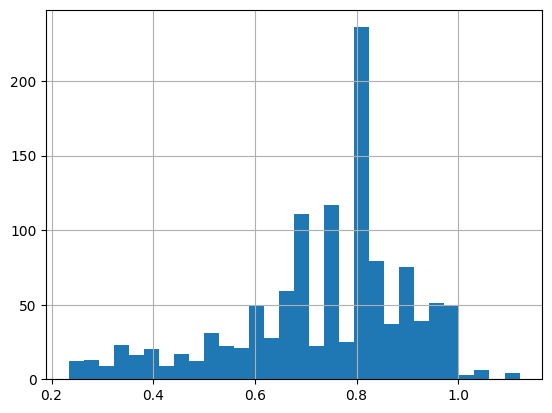

In [23]:
df_encoded["actual_productivity"].hist(bins=30)

In [24]:
model_data=df_encoded.copy()
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   targeted_productivity     1197 non-null   float64
 1   smv                       1197 non-null   float64
 2   over_time                 1197 non-null   float64
 3   incentive                 1197 non-null   float64
 4   actual_productivity       1197 non-null   float64
 5   dia_del_año               1197 non-null   float64
 6   no_of_workers_redondeado  1197 non-null   float64
 7   department_sweing         1197 non-null   float64
 8   day_Saturday              1197 non-null   float64
 9   day_Sunday                1197 non-null   float64
 10  day_Thursday              1197 non-null   float64
 11  day_Tuesday               1197 non-null   float64
 12  day_Wednesday             1197 non-null   float64
 13  team_2                    1197 non-null   float64
 14  team_3  

#
Aqui se elige separar el dataset en 80-20 entre los datos de entrenamiento y prueba.

In [25]:
X = model_data.drop('actual_productivity', axis=1)
y = model_data['actual_productivity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Aqui se elige solo una capa intermedia con un total de 32 neuronas.

In [26]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)), 
    Dense(1,  activation='linear')  
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_scaled, y_train, epochs=50, batch_size=32)

y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print(f"Out-of-Sample R²: {r2}")

Epoch 1/50
30/30 [==============================] - 1s 4ms/step - loss: 0.8334
Epoch 2/50
30/30 [==============================] - 0s 7ms/step - loss: 0.3577
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1983
Epoch 4/50
30/30 [==============================] - 0s 7ms/step - loss: 0.1229
Epoch 5/50
30/30 [==============================] - 0s 5ms/step - loss: 0.0891
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0705
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0594
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0513
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0456
Epoch 10/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0417
Epoch 11/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 12/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 13/50
30/30 [==============================

##### Se crea el segundo modelo con dos capas intermedias pero con el mismo numero de neuronas.

In [27]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),  
    Dense(1,  activation='linear') 
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_scaled, y_train, epochs=50, batch_size=32)

y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print(f"Out-of-Sample R²: {r2}")


model2 = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),  
    Dense(32, activation='relu'),  
    Dense(1,  activation='linear')  
])

model2.compile(optimizer='adam', loss='mean_squared_error')

model2.fit(X_train_scaled, y_train, epochs=50, batch_size=32)

y_pred2 = model2.predict(X_test_scaled)
r2_2 = r2_score(y_test, y_pred2)
print(f"Out-of-Sample R² for model2: {r2_2}")

Epoch 1/50
30/30 [==============================] - 2s 5ms/step - loss: 1.5121
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6142
Epoch 3/50
30/30 [==============================] - 0s 5ms/step - loss: 0.3137
Epoch 4/50
30/30 [==============================] - 0s 5ms/step - loss: 0.1883
Epoch 5/50
30/30 [==============================] - 0s 5ms/step - loss: 0.1297
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.1007
Epoch 7/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0840
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0724
Epoch 9/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0639
Epoch 10/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0570
Epoch 11/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0512
Epoch 12/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0468
Epoch 13/50
30/30 [==============================

### Funcion de generacion de Modelos y escogecencia del Mejor

Se hace una funcion para que escoja el mejor modelo con base en el $R^2$ por fuera de la muestra para poder que este se impreso en un archivo aparte con ayuda de la libreria pickle.

In [28]:
def save_optimal_model(n_epochs, X_train_scaled, y_train, X_test_scaled, y_test):

    model1 = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(1, activation='linear')
    ])
    model1.compile(optimizer='adam', loss='mean_squared_error')
    model1.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=32)
    y_pred1 = model1.predict(X_test_scaled)
    r2_1 = r2_score(y_test, y_pred1)
    gist_1 = "1 Layer: 32 Neurons (ReLU)"

    model2 = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model2.compile(optimizer='adam', loss='mean_squared_error')
    model2.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=32)
    y_pred2 = model2.predict(X_test_scaled)
    r2_2 = r2_score(y_test, y_pred2)
    gist_2 = "2 Layers: 32 Neurons each (ReLU)"

    evaluations = pd.DataFrame({'Model': ['Model 1', 'Model 2'], 
                                'Out-of-Sample R²': [r2_1, r2_2],
                                'Model Gist': [gist_1, gist_2]})
    
    evaluations.to_excel('model_evaluations.xlsx', index=False)

    best_model = model1 if r2_1 > r2_2 else model2
    with open('best_model.pkl', 'wb') as file:
        pickle.dump(best_model, file)

    return evaluations


evaluations = save_optimal_model(50, X_train_scaled, y_train, X_test_scaled, y_test)

Epoch 1/50
30/30 [==============================] - 1s 2ms/step - loss: 0.9979
Epoch 2/50
30/30 [==============================] - 0s 2ms/step - loss: 0.3035
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.1717
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.1297
Epoch 5/50
30/30 [==============================] - 0s 2ms/step - loss: 0.1070
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0899
Epoch 7/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0778
Epoch 8/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0683
Epoch 9/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0602
Epoch 10/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 11/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0491
Epoch 12/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0450
Epoch 13/50
30/30 [==============================